## Imports 

In [1]:
import pywt

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from math import sqrt,log10
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

## Denoising EEG Signals using Discrete Wavelet Transform 

__Steps to denoise signals :__
  1. Perform multilevel wavelet decomposition using the wavedec() function from PyWavelets module.
  2. Select a thresholding technique.
  3. Apply thresholding and reconstruct the signal using the waverec() function from the PyWavelets module.
  
The Discrete Wavelet Transform splits the input signal into low pass and high pass subbands. The low pass subband is also called the _approximation coefficient_ and the high pass subband is also called the _detail coefficient_ . The approximation coefficient can be further split up on multiple levels. This is known as _Multilevel Wavelet Decomposition_.

Once we perform the multilevel wavelet decomposition we want to select a suitable thresholding technique. For our purposes we will use the universal thresholding technique as it is very convienient and the universal threshold is easy to compute.

\begin{equation*}
\text{Universal Threshold} = \frac{\Bigl(\sqrt{2 \text{log(length(X))}} \Bigr) \text{median(abs(D))} }{0.6745}
\end{equation*}

where,
   - __X__ is the signal
   - __D__ is the set of first level detail coefficients

Using the Universal threshold we will apply hard thresholding to the signal, which is a type of thresholding technique where all coefficients below the calculated threshold are reduced to 0 and all the coefficients above the threshold value are left unchanged.

After thresholding the signal is reconstructed using the waverec() function.

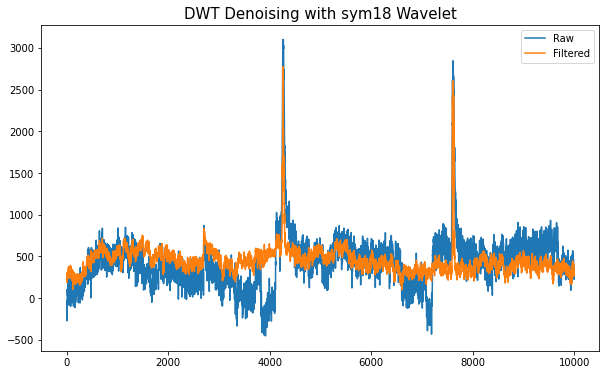

In [2]:
def madev(d, axis=None):
    """ Median absolute deviation of a signal """
    return np.median(np.absolute(d))

def wavelet_denoising(x):
    c = pywt.wavedec(x,"sym18", mode="per",level = 4)
    
    sigma = (1/0.6745) * madev(c[-1])
    
    univ_thresh = sigma * np.sqrt(2 * np.log(len(x)))
    
    c[1:] = (pywt.threshold(i, value=univ_thresh, mode='hard') for i in c[1:])
    
    return pywt.waverec(c, "sym18", mode='per')


signal = pd.read_csv('data/train/subj1_data.csv')
signal = signal.drop("id", axis=1)

filtered = pd.DataFrame(wavelet_denoising(signal))

###PLOT###
plt.figure(figsize=(10, 6))
plt.plot(signal.iloc[:10000,0], label='Raw')
plt.plot(filtered.iloc[:10000,0], label='Filtered')
plt.legend()
plt.title("DWT Denoising with sym18 Wavelet", size=15)
plt.show()


## Feature Extraction of EEG Signals using Discrete Wavelet Transform

The wavedec() function performs 1D multilevel Discrete Wavelet Transform decomposition of a given signal and returns an ordered list of coefficients arrays in the form : [cA_n, cD_n, cD_n-1, ..., cD2, cD1]

where n denotes the level of decomposition. The first element (cA_n) of the result is the 
approximation coefficients array and the following elements (cD_n - cD_1) are detailed 
coefficients arrays.

Now coming to the point of different frequency bands

Discrete wavelet transform will always return only one approximation coefficient.

If starting frequency band of the eeg waveform is 0-64 Hz then at level =1 we will get 
0-32 Hz which gives approximation coefficients & another band is 32-64Hz which gives the detail 
coefficient of the wavelet.

At level = 2, the discrete wavelet transform will return 3 frequency bands:
1. 0-16 Hz i.e. approximation coefficients
2. 16-32 Hz i.e. detail coefficients
3. 32-64 Hz i.e. detail coefficients.
and so on 

Since the sampling frequency of our eeg data is 500Hz, 
therefore by Nyquist-Shanon Theorem,
the highest frequency in our waveform will be 250 Hz 
then at level =1 we will get 
    0-125 Hz which gives approximation coefficients & another band is 
    125-250Hz which gives the detail coefficient of the wavelet.

Therefore at level = 5, the discrete wavelet transform will return 3 frequency bands:
1. 0 - 7.8125 Hz i.e. approximation coefficients 
2. 7.8125 - 15.625 Hz ~ Alpha Frequency Band
3. 15.625 -31.25 Hz ~ Beta Frequency Band
4. 31.25 - 62.5 Hz 
5. 62.5 - 125 Hz 
6. 125 - 250 Hz

The aim is to extract Alpha and Beta frequencies as they correspond to motor function.

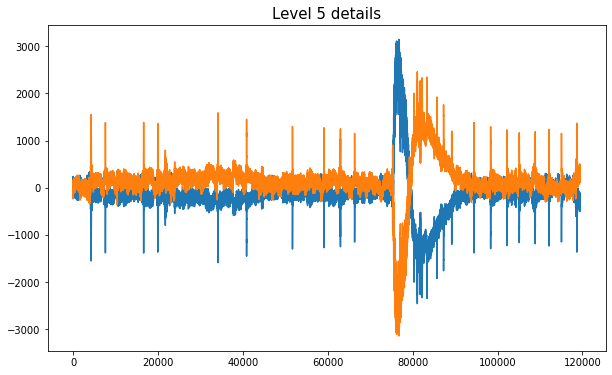

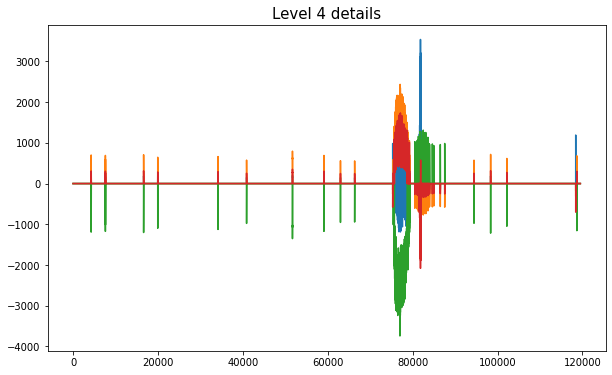

In [3]:
def FEdwt(s):
    coefli = pywt.wavedec(s,"sym18", mode="per", level=5)
    return coefli

cli = FEdwt(filtered)

i = 5
for c in cli[1:3:]:
    d = pd.DataFrame(pywt.idwt(None, c,"sym18", mode="per"))
    
    ###PLOT###
    plt.figure(figsize=(10, 6))
    plt.plot(d.iloc[:], label='')
    plt.title(f"Level {i} details", size=15)
    plt.show()
    i-=1